## Demonstration of layer sharing on LeNet-5

In [1]:
import torch
import torch.nn as nn
import pandas as pd

from data.mnist import MnistDataset
from models.lenet.lenet import LeNet5
from utils.train import *
from utils.quantize import *
from utils.weight_sharing import *
from utils.plot import *

Parameters

In [2]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32
N_CLASSES = 10
DEVICE = None
EPOCHS = 100

NET_PATH = './models/lenet/saves/lenet.save'
SAVE_DATA = './results/test_share.csv'

Setting up the components

In [3]:
dataset = MnistDataset(BATCH_SIZE, './data', val_split=0.5)
model = LeNet5(N_CLASSES)
criterion = nn.CrossEntropyLoss()

lam_opt = lambda mod : torch.optim.Adam(mod.parameters(), lr=LEARNING_RATE)
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)
lam_test = lambda : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller = WeightShare(model, lam_opt, lam_train, lam_test)
ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


Getting the network

In [4]:
optimizer = lam_opt(model)
train_settings = [criterion, optimizer, dataset, EPOCHS, DEVICE, 1, True]

get_trained(model, NET_PATH, train_settings)

TEST - Sharing the whole network to given parameters

In [5]:
"""
ws_controller.share([50, 100, 400, 100, 20], [0,2,4], [1, 0, 1, 0, 2])

ws_controller.print_layers_info()

lam_test()
"""

'\nws_controller.share([50, 100, 400, 100, 20], [0,2,4], [1, 0, 1, 0, 2])\n\nws_controller.print_layers_info()\n\nlam_test()\n'

Setting scoring functions

In [6]:
before_loss = get_accuracy(model, dataset.test_dl, DEVICE)

lam_score1 = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)
lam_score2 = lambda layer : layer.compression_rate()
lam_score3 = lambda _ : (get_accuracy(model, dataset.test_dl, DEVICE) + get_accuracy(model, dataset.valid_dl, DEVICE)\
    + get_accuracy(model, dataset.train_dl, DEVICE)) / 3 

TEST - sharing whole network with pre score-functions

In [7]:
"""
lam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)

def pre_perf(layer):
    opt = lam_opt(model)
    lam_train(opt, 1)

ws_controller.get_layer_cluster_nums_perf(1, range(10,20), [lam_score1, lam_score2], pre_perf)
ws_controller.get_layer_cluster_nums_perf(1, range(10,100), [lam_score1, lam_score2])
"""

'\nlam_train = lambda opt, epochs : train_net(model, criterion, opt, dataset, epochs, device=DEVICE)\n\ndef pre_perf(layer):\n    opt = lam_opt(model)\n    lam_train(opt, 1)\n\nws_controller.get_layer_cluster_nums_perf(1, range(10,20), [lam_score1, lam_score2], pre_perf)\nws_controller.get_layer_cluster_nums_perf(1, range(10,100), [lam_score1, lam_score2])\n'

Getting optimal num of clusters for a given layer

In [8]:
data = {
    'num clusters': [],
    'accuracy': [],
    'layer': []
}

data_types = {
    'num clusters': 'int16',
    'accuracy': 'float32',
    'layer': 'uint8'
}

share_data = pd.DataFrame(data).astype(data_types)

for layer in [0, 4]:
    scores = ws_controller.get_layer_cluster_nums_perf(layer, range(2,3), [lam_score1])
    
    for item in scores:
        share_data = share_data.append({
            'num clusters': item[0],
            'accuracy loss': (before_loss - item[1][0]),
            'layer': layer,
        }, ignore_index=True).astype(data_types)

share_data.to_csv(SAVE_DATA, index=False)

Pot data

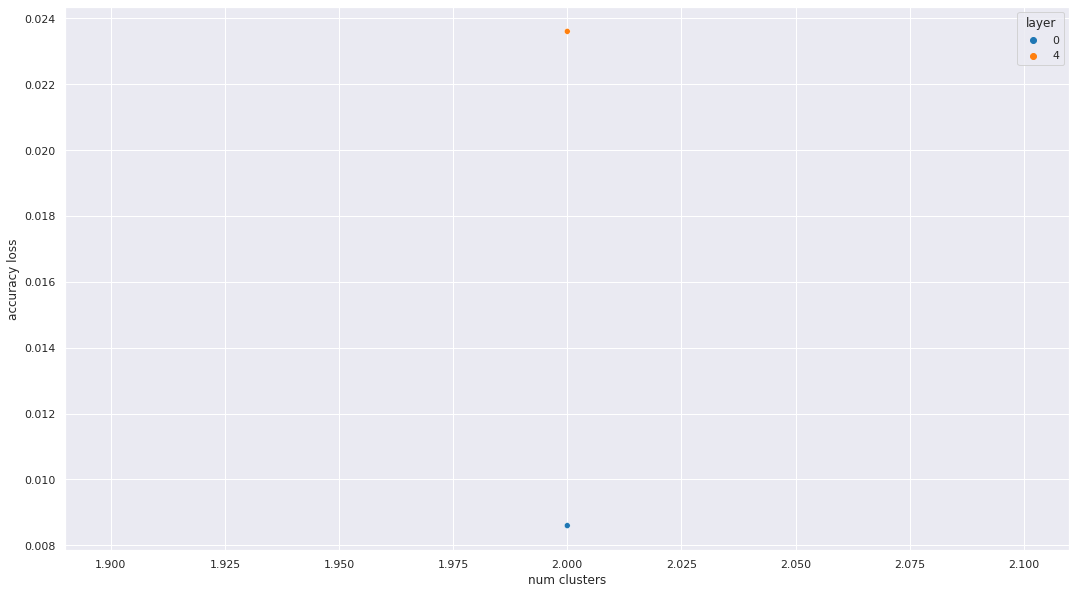

In [9]:
plot_alncl(share_data)

After measurements the net is not changed

In [10]:
ws_controller.print_layers_info()

layer_name #weights #bias w_locked CR
feature_extractor.0 150 6 False 1.00
feature_extractor.3 2400 16 False 1.00
feature_extractor.6 48000 120 False 1.00
classifier.0 10080 84 False 1.00
classifier.2 840 10 False 1.00
Sum num weights, bias:  61470 236
Compression rate 1.00


In [11]:
layer_ranges = [range(1, 10), range(1, 10), range(1, 10), range(1, 10), range(1, 10)]
lam_score1 = lambda _ : get_accuracy(model, dataset.test_dl, DEVICE)

ws_controller.get_optimized_layer_ranges(layer_ranges, lam_score1, 0.98, savefile='./results/lol.csv')

[[[3, 0.9838], [4, 0.985], [5, 0.9848], [6, 0.9846], [7, 0.9846], [8, 0.9852], [9, 0.9854]], [[4, 0.9826], [6, 0.985], [7, 0.9852], [8, 0.9846], [9, 0.9842]], [[5, 0.9806], [6, 0.9844], [7, 0.9834], [8, 0.9852], [9, 0.985]], [[4, 0.9826], [5, 0.9824], [6, 0.9846], [7, 0.9854], [8, 0.985], [9, 0.9846]], [[4, 0.9844], [5, 0.9854], [6, 0.9846], [7, 0.9858], [8, 0.986], [9, 0.986]]]
